# End to End Inference Tutorial
Here we implement a complete end-to-end use of paltas. This notebook is intended as a 'minimal reproducible example', and thus doesn't use the full extent of the package, but should be a useful starting point. \
A number of the code-blocks simply run command-line instructions. This is intentional, as paltas is designed to run in the command-line. Furthermore, running such command-line statements allows easier transfer to remote computing clusters/parallelisation.


# Goals

1. To be able to implement a simple end-to-end example of Paltas
2. To understand how each of the packages inter-communicate, and which packages need to be run (and when), to perform hierarchichal inference.

# Import Packages
Here we import the required packages and define the training and model directories (where the training images and model weights are stored, respectively).\
The '/home/runner/work' referred to here is required to run this notebook as a Github Action, but should be changed to a prefered directory when running this notebook locally.\
Although tensorflow, emcee and ipython do not form part of the requirements for paltas, they are required for this notebook.

In [1]:
import os
os.getcwd()

'/global/u2/p/phil1884/paltas/notebooks'

In [2]:
#paltas_directory = './'
#training_directory = '/home/runner/work/notebooks/End_to_End_Tutorial_Files/' #For github actions
#model_directory = '/home/runner/work/notebooks/End_to_End_Tutorial_Files/'
training_directory = '/global/u2/p/phil1884/paltas/notebooks/End_to_End_Tutorial_Files' #For NERSC
model_directory = '/global/u2/p/phil1884/paltas/notebooks/End_to_End_Tutorial_Files'
paltas_directory = '/global/u2/p/phil1884/paltas/'
import os
os.chdir(paltas_directory)
from paltas.Analysis import hierarchical_inference,dataset_generation, loss_functions, conv_models
from IPython.display import display,Pretty
import matplotlib.pyplot as pl
from scipy.stats import norm
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import corner
import emcee
import numba
import h5py
import glob
import sys
random_seed = 4
np.random.seed(random_seed)
tf.random.set_seed(random_seed)


# Generate Images
We start by generating lensed images divided into training and validation sets. The images are saved within one h5 file for each run of generate.py. We'll first look at the configuration file used to determine the properties of the generated images:

In [ ]:
display(Pretty("./paltas/Configs/Examples/config_simple_tutorial.py"))

We then run the image generation:

In [8]:
!python3 ./paltas/generate.py ./paltas/Configs/Examples/config_simple_tutorial.py /$training_directory/training/1 --n 100 --tf_record --h5
!python3 ./paltas/generate.py ./paltas/Configs/Examples/config_simple_tutorial.py /$training_directory/validation/1 --n 100 --tf_record --h5

2023-09-22 15:12:57.374073: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 15:12:58.158053: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/homes/p/phil1884/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/r

# Train Model
The neural network is then trained. The --h5 indicates that the images were originally saved as h5 files, and should be retrieved as such. Again, most of the work is done by the configration file, so we'll inspect that first. We define the learning parameters (the lens properties the network should determine), in this file - we chose the Einstein radius, shear, power-law slope, position and ellipticity in this example. 

In [10]:
display(Pretty("./paltas/Analysis/AnalysisConfigs/train_config_examp_tutorial.py"))

import os
from glob import glob
import numpy as np
batch_size = 256
# The number of epochs to train for
n_epochs = 5
# The size of the images in the training set
img_size = (60,60,1)
# A random seed to us
random_seed = 2
# The list of learning parameters to use
learning_params = ['main_deflector_parameters_theta_E',
	'main_deflector_parameters_gamma1','main_deflector_parameters_gamma2',
	'main_deflector_parameters_gamma','main_deflector_parameters_e1',
	'main_deflector_parameters_e2','main_deflector_parameters_center_x',
	'main_deflector_parameters_center_y']
log_learning_params = []
# Which parameters to consider flipping
flip_pairs = None
# Which terms to reweight
weight_terms = None

#directory_to_save_model = '/home/runner/work/notebooks/End_to_End_Tutorial_Files/' #Github actions
#directory_for_training_images =  '/home/runner/work/notebooks/End_to_End_Tutorial_Files/'
#directory_for_validation_images =  '/home/runner/work/notebooks/End_to_End_Tutorial_Files/'
directory_to_save_mo

In [16]:
!python3 ./paltas/Analysis/train_model.py ./paltas/Analysis/AnalysisConfigs/train_config_examp_tutorial.py --h5

2023-09-22 15:20:04.007997: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 15:20:04.904279: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/global/common/software/nersc/pm-2022q3/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/homes/p/phil1884/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/r

# Generate Model Predictions
Having trained the model, we locate the filename of the final epoch (this can be hardcoded instead if desired).

In [17]:
def load_model_weights_list(directory):
    """ Function to return a list of weights filenames from the network
    args: Directory containing the training, validation and weights files """
    weights_list = glob.glob(f'{directory}/model_weights/*')
    weights_list = [elem.split('model_weights/')[1] for elem in weights_list]
    return weights_list

def return_final_epoch_weights(directory):
    """ File to return the weight filename of the final trained epoch
    args: Directory containing the training, validation and weights files """
    weights_list = load_model_weights_list(directory)
    print(weights_list)
    final_epoch =  np.max([int(elem.split('-')[0]) for elem in weights_list])
    w_filename = [x for x in weights_list if x.startswith("{:02d}".format(final_epoch)+'-')][0]
    print('FINAL EPOCH',w_filename)
    return directory+'/model_weights/'+w_filename

final_weights_filename = return_final_epoch_weights(model_directory)

['02-7.73.h5', '05-4.52.h5', '03-6.40.h5', '04-6.04.h5', '01-9.71.h5']
FINAL EPOCH 05-4.52.h5


## Configuration
The trained model is loaded (along with the network weights from the final epoch).

In [18]:
def load_model(model_weights_filename,loss_type,model_type,learning_params,log_learning_params,img_size):
    """ Loads the trained model
    args: 
    model_weights_filename (str): .h5 file containing the weights of the trained model.
    loss_type (str): 'full' or 'diag', depending on the type of covariance matrix chosen
    model type (str): 'xresnet34' or 'xresnet101', according to the choice of network
    learning_params (list of str): Parameters learnt by the network
    img_size (int): Dimensions of the input images"""
    num_params = len(learning_params+log_learning_params)
    if loss_type == 'full':
        num_outputs = num_params + int(num_params*(num_params+1)/2)
        loss_func = loss_functions.FullCovarianceLoss(num_params)
    elif loss_type == 'diag':
        num_outputs = 2*num_params
        loss_func = loss_functions.DiagonalCovarianceLoss(num_params)
    if model_type == 'xresnet101':
        model = conv_models.build_xresnet101(img_size,num_outputs)
    if model_type == 'xresnet34':
        model = conv_models.build_xresnet34(img_size,num_outputs)
    model.load_weights(model_weights_filename,by_name=True,skip_mismatch=True)
    return model,loss_func,num_params

#Import training configs
from paltas.Analysis.AnalysisConfigs.train_config_examp_tutorial import learning_params,batch_size,flip_pairs,\
                                                               n_epochs,random_seed,norm_images,\
                                                               loss_function,model_type,\
                                                               npy_folders_train,img_size


corner_param_print= [elem.replace('main_deflector_parameters_','').replace('subhalo_parameters_','').\
                     replace('theta','\Theta').replace('gamma','\gamma') for elem in learning_params]

model,loss_func,num_params = load_model(final_weights_filename,loss_function,learning_params=learning_params,\
                             log_learning_params=[],model_type=model_type,img_size=img_size)

2023-09-22 15:21:26.556862: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Generate Network Predictions
The network predictions are then loaded, for testing on the validation set generated above

In [19]:
def gen_network_predictions(test_folder,norm_path,learning_params,log_learning_params,loss_type,
                            loss_func,model,shuffle=True,
                            norm_images=True,log_norm_images=False):
    """
    Generate neural network predictions given a paltas generated folder of images

    Args:
        test_folder (string): Path to folder of paltas generated images, 
            containig a data.tfrecord file
        norm_path (string): Path to .csv containing normalization of parameters
            applied during training of network
        learning_params (list(string)): Names of parameters learned
        loss_type (string): only 'diag' currently supported for this notebook
        loss_func (paltas.Analysis.loss_function): Loss function object, (needs
            draw_samples() and convert_output() functionality)
        model (paltas.Analysis.conv_models): Trained neural network with weights
            loaded
        shuffle (bool, default=True): If True, the order of the test set is shuffled
            when generating predictions
        norm_images (bool, default=True): If True, normalize test set images
        log_norm_images (bool, default=False): If True, test set imags are
            log-normalized and rescaled to range (0,1)

    Returns:
        y_test, y_pred, std_pred, prec_pred
    """

    tfr_test_path = os.path.join(test_folder,'data.tfrecord')
    input_norm_path = norm_path
    #The following code implementation here and in the hierarchical inference function below assumes a diagonal covariance matrix
    if loss_type !='diag':
        raise ValueError('loss_type not supported in this notebook')
    tf_dataset_test = dataset_generation.generate_tf_dataset(tf_record_path = tfr_test_path,\
                                                             learning_params = learning_params,
                                                             batch_size = 3,\
                                                             n_epochs = 1,\
                                                             norm_images=norm_images,
                                                             kwargs_detector=None,\
                                                             input_norm_path=input_norm_path,
                                                             log_learning_params=log_learning_params,\
                                                             shuffle=shuffle)

    y_test_list = [];y_pred_list = []
    std_pred_list = [];cov_pred_list = []
    predict_samps_list = []

    for batch in tf_dataset_test:
        images = batch[0].numpy()
        y_test = batch[1].numpy()
        
        # use unrotated output for covariance matrix
        output = model.predict(images)
        y_pred, log_var_pred = loss_func.convert_output(output)

        # compute std. dev.
        std_pred = np.exp(log_var_pred/2)
        cov_mat = np.empty((len(std_pred),len(std_pred[0]),len(std_pred[0])))
        for i in range(len(std_pred)):
            cov_mat[i] = np.diag(std_pred[i]**2)

        y_test_list.append(y_test)
        y_pred_list.append(y_pred)
        std_pred_list.append(std_pred)
        cov_pred_list.append(cov_mat)

    y_test = np.concatenate(y_test_list)
    y_pred = np.concatenate(y_pred_list)
    std_pred = np.concatenate(std_pred_list)
    cov_pred = np.concatenate(cov_pred_list)

    if input_norm_path is not None:
        dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_pred,standard_dev=std_pred,cov_mat=cov_pred)
        dataset_generation.unnormalize_outputs(input_norm_path,learning_params+log_learning_params,
                                        y_test)
    prec_pred = np.linalg.inv(cov_pred)
   
    return y_test, y_pred, std_pred, prec_pred

In [20]:
network_predictions = gen_network_predictions(\
                        test_folder=training_directory+'/validation/1',\
                        norm_path=training_directory+'/training/1/norms.csv',\
                        learning_params=learning_params,\
                        log_learning_params = [],\
                        loss_type=loss_function,
                        loss_func=loss_func,\
                        model=model,shuffle=True,
                        norm_images=norm_images,log_norm_images=False)

/global/u2/p/phil1884/paltas/paltas/Analysis/dataset_generation.py:278: UserWarning: No noise will be added
  warnings.warn('No noise will be added')


1/1 [==============================] - 0s 35ms/step


## Plot Network Output Distributions
We now plot the distributions of the network predictions, and compare those to the ground-truth

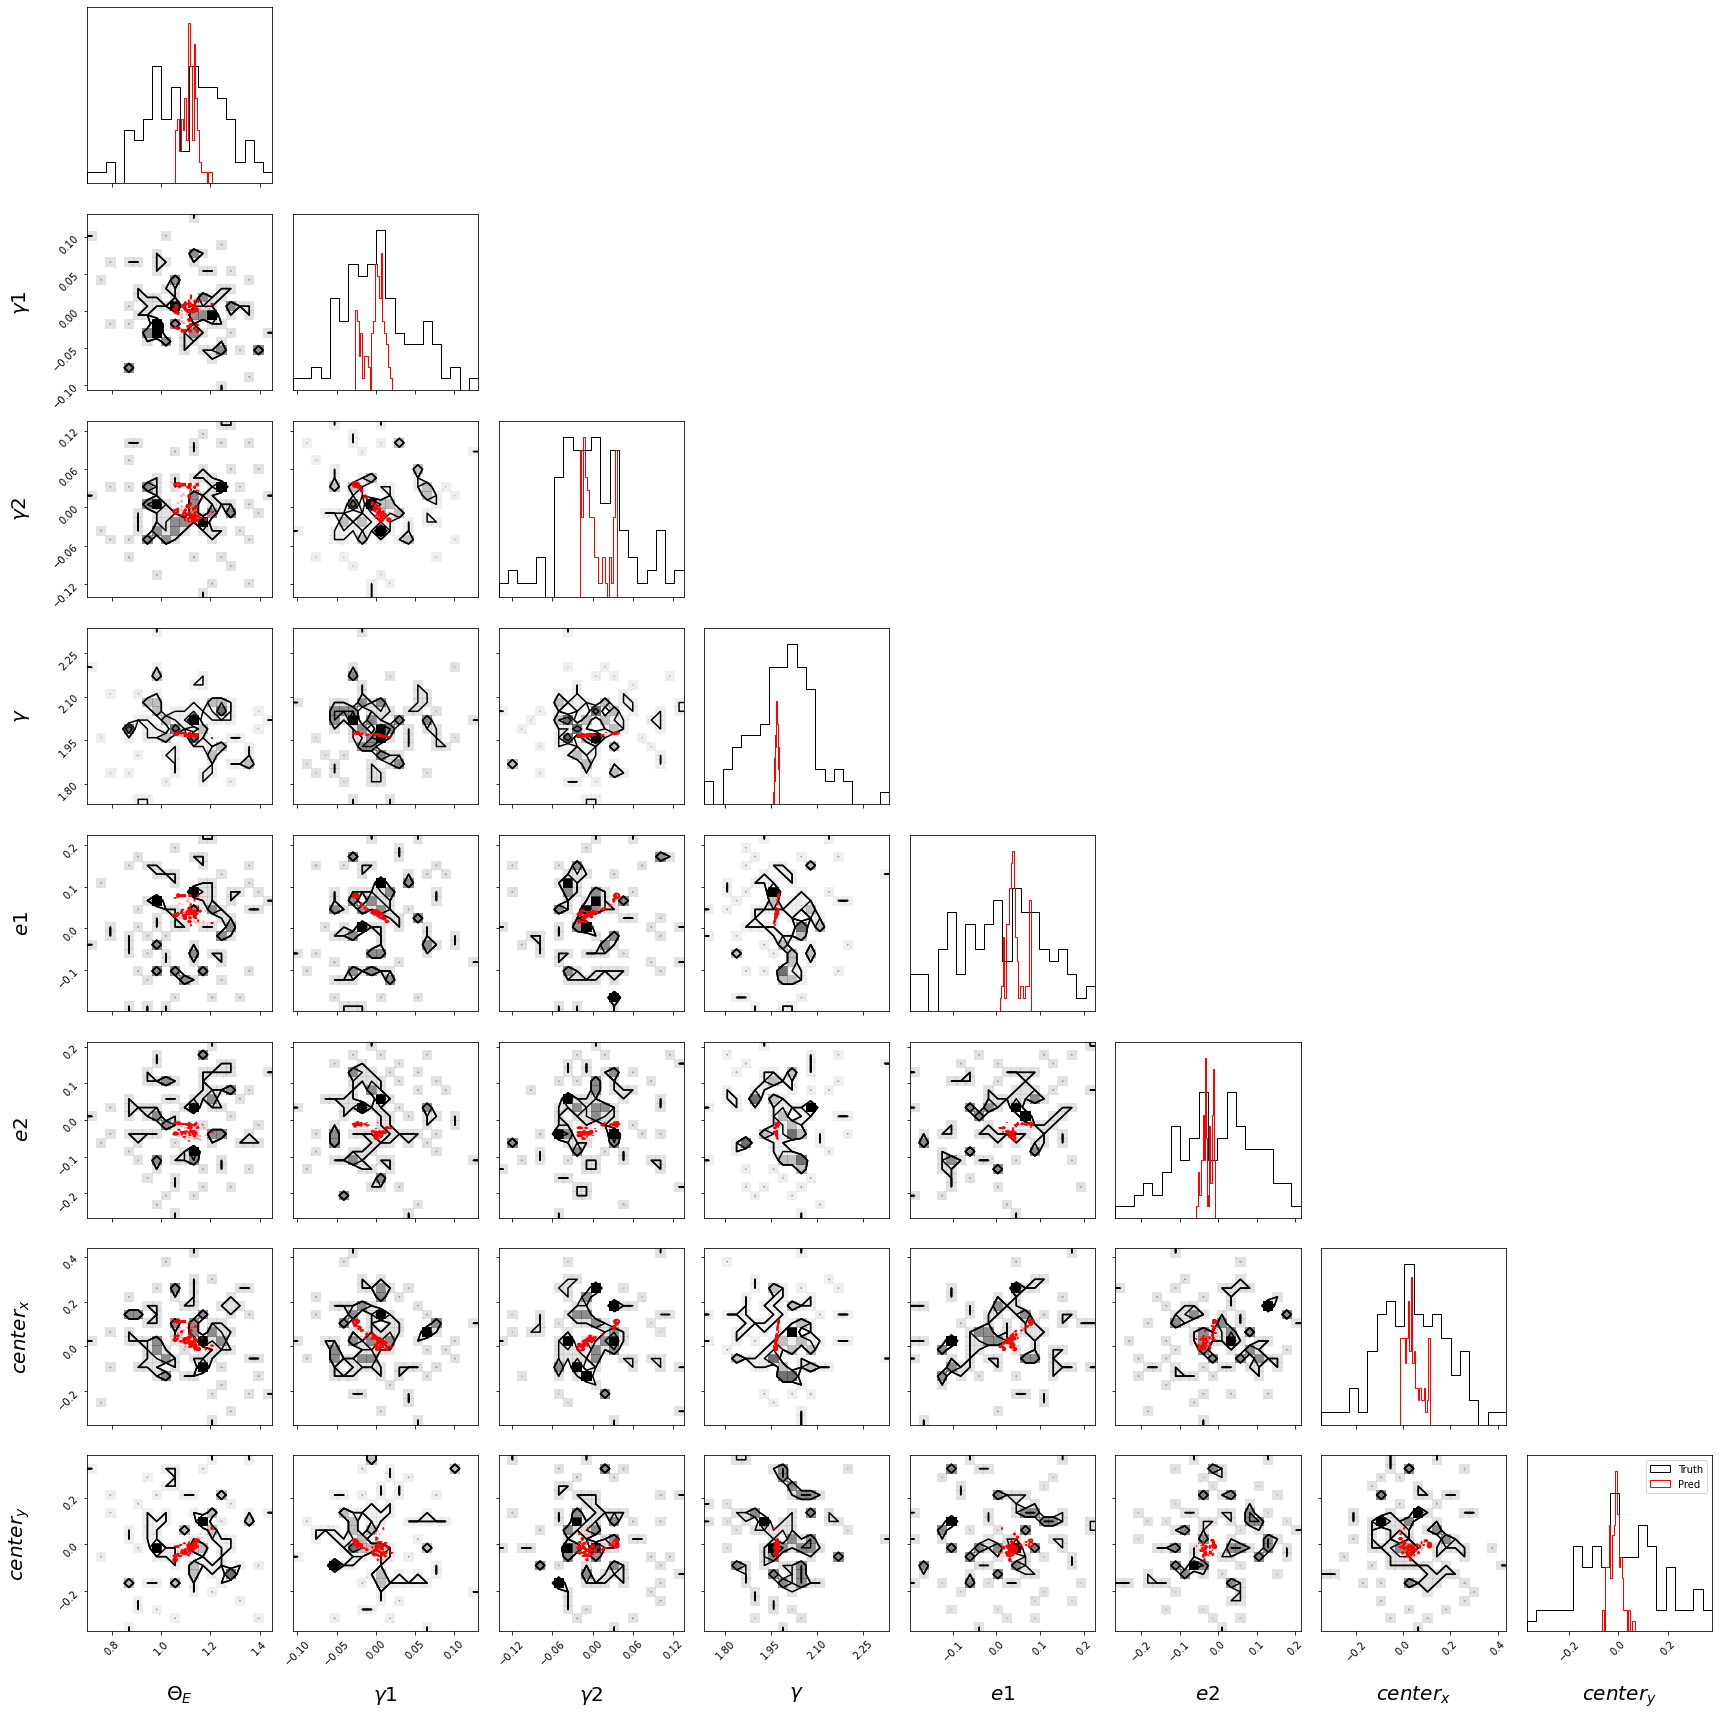

In [21]:
label_kwargs = {'fontsize': 20}
fig = pl.figure(figsize=(3*len(learning_params),3*len(learning_params)))
corner.corner(network_predictions[0],fig=fig,color='k')
corner.corner(network_predictions[1],fig=fig,color='red',\
              labels=['$'+elem+'$' for elem in corner_param_print],\
              label_kwargs=label_kwargs)
pl.legend(['Truth','Pred'])
pl.tight_layout()
pl.show()

## Load Model Outputs
The hyperparameters of the training set are loaded (to use as an interim prior in the hierarchical inference), along with the network predictions for the validation set

In [22]:
train_mean = np.array(pd.read_csv(training_directory+'/training/1/norms.csv')['mean']) 
train_scatter = np.array(pd.read_csv(training_directory+'/training/1/norms.csv')['std']) 

#Since we are using a diagonal covariance matrix, the precision matrix is the diagonal matrix of
#the (elementwise) values of 1/std^2. In general however it is inv(cov_matrix).
network_means = network_predictions[1][:,:].astype('float64')              
network_prec = network_predictions[3][:,:,:].astype('float64')

# Hierarchical Inference
The following performs hierarchical inference to retrieve the population hyperparameters of the validation set, assuming a diagonal covariance matrix.

In [23]:
def hierarchical_inference_func(n_lenses,y_pred,prec_pred,train_mean,train_scatter,n_param=None,n_samps = 1e+4):
    """
    Returns:
        sampler object
    """
    # Load the predictions for the mean and covariance for our model. We'll have to do a little reshaping here since the code
    # expect an array of mean values and a precision matrix.
    y_pred_hi = y_pred
    prec_pred_hi = prec_pred
    # The interim training distribution.
    mu_omega_i = np.array(train_mean)
    cov_omega_i = np.diag(np.array(train_scatter)**2)
    if n_param is None: ndim =2*num_params
    else: ndim = 2*n_param
    # uniform prior with bounds
    @numba.njit()
    def eval_func_omega(hyperparameters):
        sig_learning_params = [0.15,0.05,0.05,0.1,0.1,0.1,0.16,0.16]
        loc_learning_params = [1.1,0,0,2,0,0,0,0]
        for i in range(len(sig_learning_params)):
            if abs(hyperparameters[i]-loc_learning_params[i])>100*sig_learning_params[i]:
                return -np.inf
        # log prior for uniform in sigma space, as opposed to uniform in log space
        return 0#np.sum(hyperparameters[int(ndim/2):])

    # Initialize our class and then give it the network predictions. These are set to global variables in case you want to use
    # pooling.
    prob_class = hierarchical_inference.ProbabilityClassAnalytical(mu_omega_i,cov_omega_i,eval_func_omega)
    prob_class.set_predictions(mu_pred_array_input=y_pred_hi,prec_pred_array_input=prec_pred_hi)

    # Set a few of the parameters we will need to pass to emcee
    n_walkers = 40
    # Generate an initial state informed by prior range
    cur_state_mu = np.concatenate([np.random.uniform(low=-10,high=10,size=(n_walkers,1))\
                                   for i in range(int(ndim/2))],axis=1)
    cur_state_sigmas = np.log(np.concatenate([np.random.uniform(low=0.01,high=0.1,size=(n_walkers,1))\
                                   for i in range(int(ndim/2))],axis=1))
    cur_state = np.concatenate((cur_state_mu,cur_state_sigmas),axis=1)
    sampler = emcee.EnsembleSampler(n_walkers, ndim,prob_class.log_post_omega)
    _ = sampler.run_mcmc(cur_state,n_samps,progress=True,skip_initial_state_check=True)
 
    return sampler

In [24]:
#Due to the current implementation of hierarchical_inference.ProbabilityClassAnalytical.log_post_omega, we assert
#that the covariance matrix must be diagonal for now.
assert loss_function=='diag'
burnin = int(100)

sampler = hierarchical_inference_func(1000,network_means,network_prec,\
                      train_mean[:].astype('float64'),train_scatter[:].astype('float64'),n_samps=1000)
chain = sampler.chain[:,burnin:,:].reshape((-1,2*num_params))[:,0:num_params] #Just using the means for now

  0%|          | 0/1000 [00:00<?, ?it/s]/global/homes/p/phil1884/.local/perlmutter/3.9-anaconda-2021.11/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1000/1000 [00:12<00:00, 78.33it/s]


# Results
We plot the results of the hierarchical inference here: the ground-truth is plotted as solid black lines, along with the population posterior 

In [ ]:
learning_params

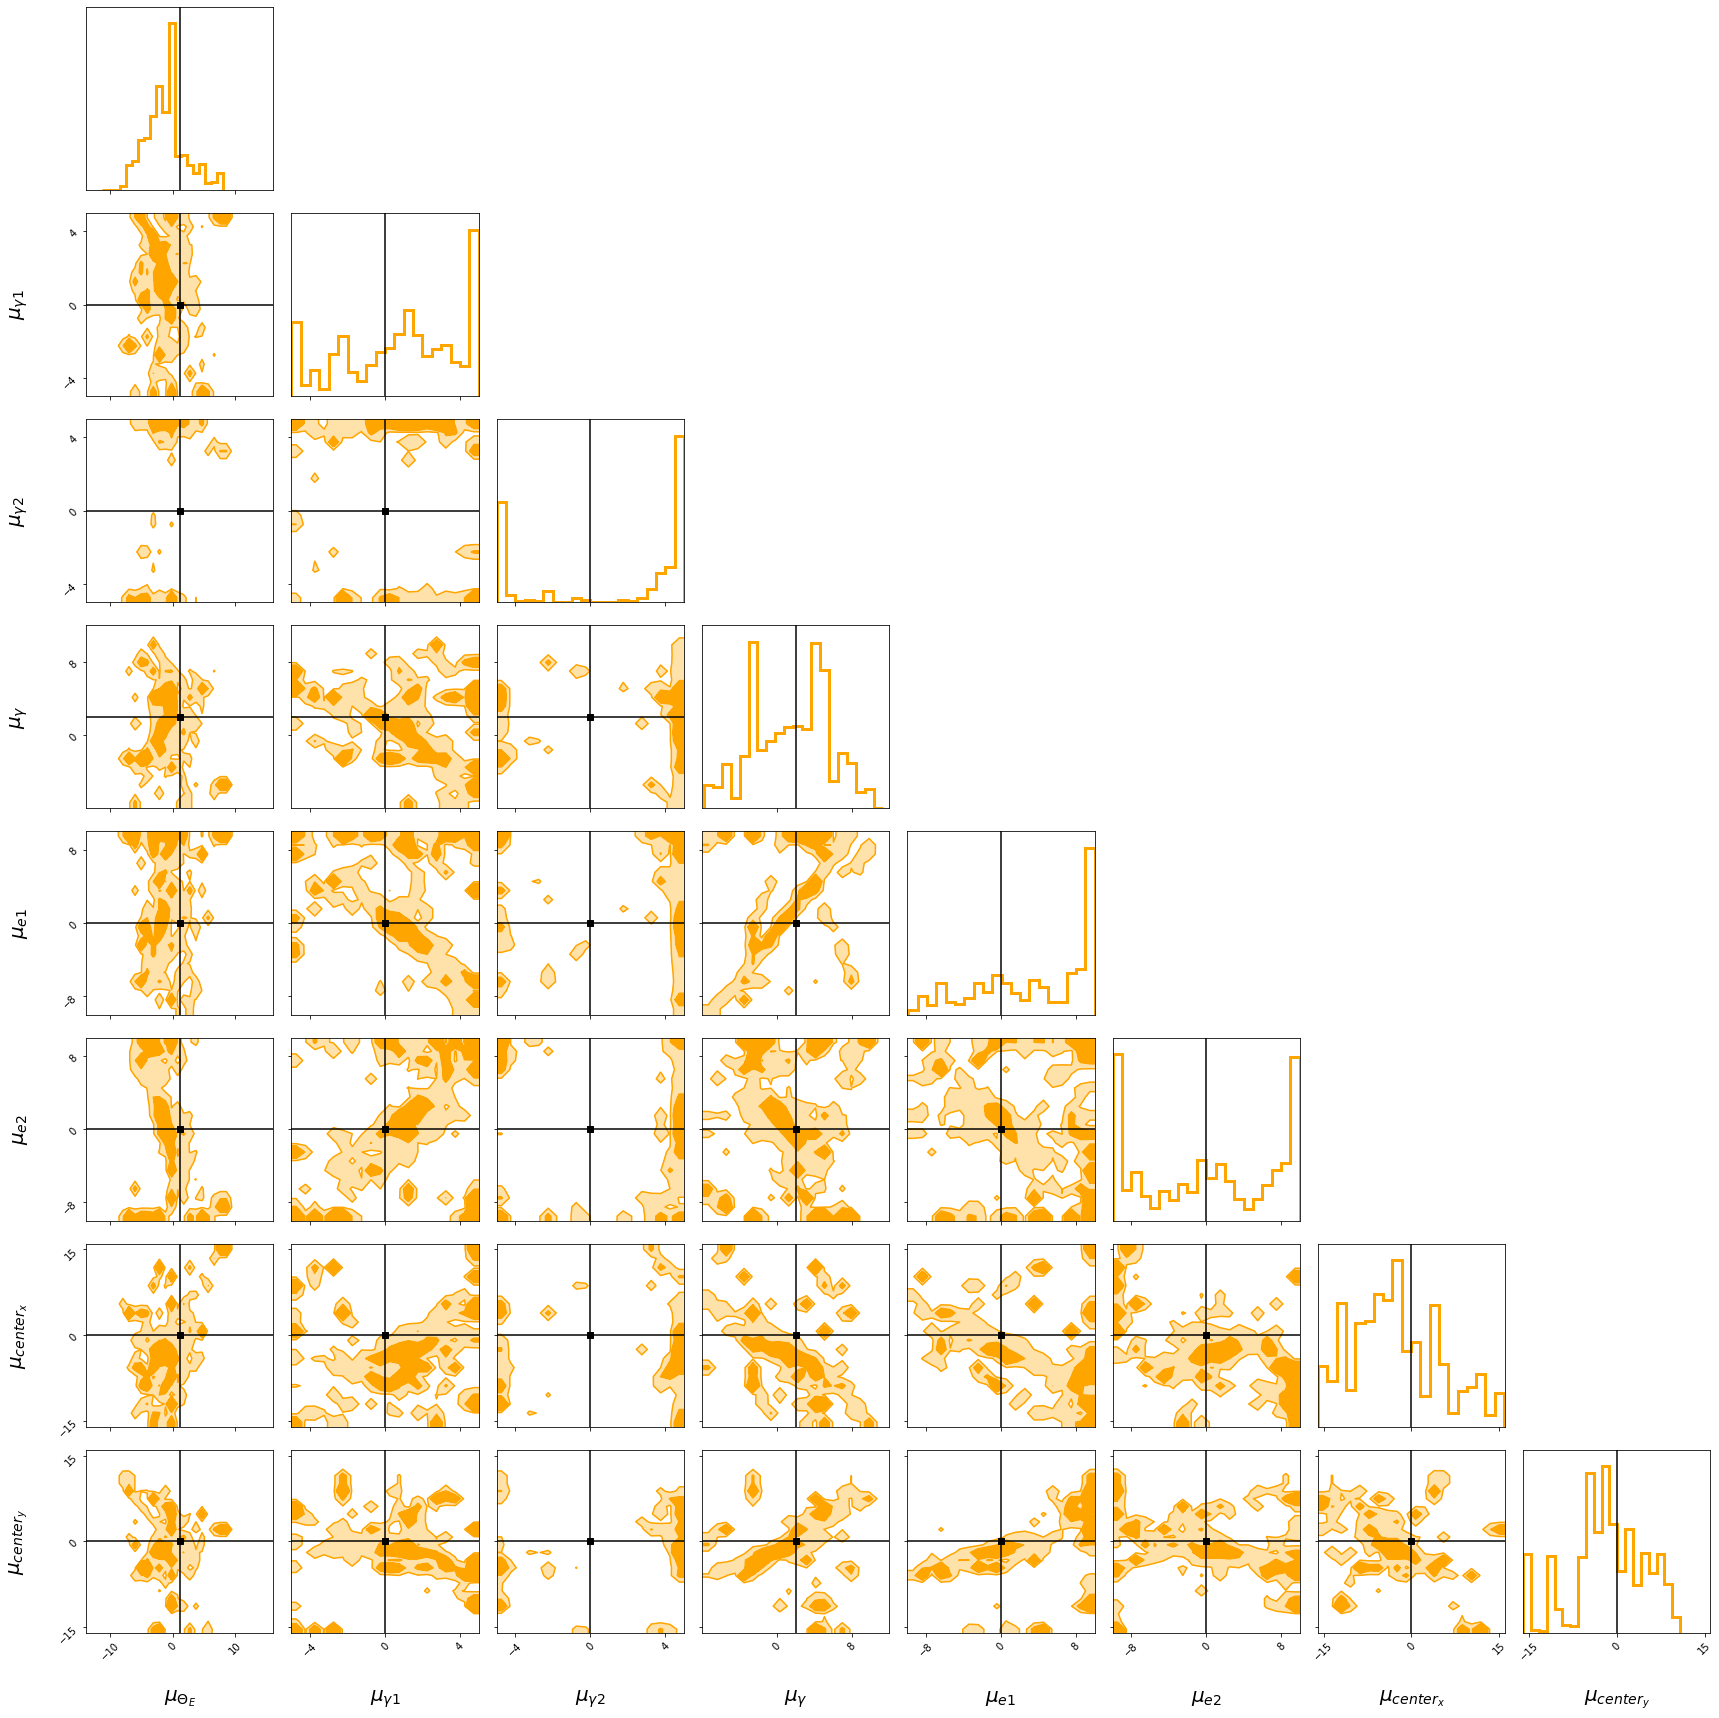

In [25]:
labels_kwargs = {'fontsize':20}
hist_kwargs = {'density':True,'color':'orange','lw':3}
fig,ax = pl.subplots(len(learning_params),len(learning_params),figsize=(3*len(learning_params),3*len(learning_params)))

corner.corner(chain,labels=['$\mu_{'+elem+'}$' for elem in corner_param_print],fig=fig,show_titles=False,plot_datapoints=False,\
              label_kwargs=labels_kwargs,\
              levels=[0.68,0.95],color='orange',fill_contours=True,hist_kwargs=hist_kwargs,title_fmt='.2f',\
              truths=[1.1,0,0,2,0,0,0,0],truth_color='k',\
              max_n_ticks=3,bins=20)
d = 10
sig_learning_params = np.array([0.15,0.05,0.05,0.1,0.1,0.1,0.16,0.16])
loc_learning_params = np.array([1.1,0,0,2,0,0,0,0])
f = 100 #Bounds of corner plot, in units of sigma
for i in range(8):
    for j in range(8):
        ax[i,j].set_xlim((loc_learning_params-f*sig_learning_params)[j],(loc_learning_params+f*sig_learning_params)[j])
        if i!=j:
            ax[i,j].set_ylim((loc_learning_params-f*sig_learning_params)[i],(loc_learning_params+f*sig_learning_params)[i])

pl.tight_layout()
pl.show()

# Endnote
We have now 1) generated simulated lensed images, 2) trained a neural network to model these images, 3) applied the trained network to a different set of images and 4) run hierarchical inference to infer population-level parameters.\
You may note that the final results could be improved - the configuration settings used here were chosen for speed rather than precision. For science-level results, the following should be changed:
1) Increase the training-set size for the neural network,
2) Increase the number of epochs the network trains for,
3) Increase the number of iterations (and burn-in) of the MCMC used for hierarchical inference.
